### Let's analysis theta power during head rotation in Lomi data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import h5py
import numpy as np
from scipy.fftpack import fft
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d
from scipy.signal import spectrogram


%load_ext autoreload
%autoreload 2


### Load eeg data, position, and head direction data

In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # List all keys
        keys = list(f.keys())
        #print(f"Keys: {keys}")

        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        light1 = sdata['light1']
        ppox = np.array(light1['pox']).squeeze()
        ppoy = np.array(light1['poy']).squeeze()
        pot = np.array(light1['pot']).squeeze()
        poh = np.array(light1['poh']).squeeze()
        pov = np.array(light1['pov']).squeeze()
        
        eeg = np.array(sdata['eeg']).squeeze()
        eegVolts = np.array(sdata['eegVolts']).squeeze()
        eeg_filtered = np.array(sdata['eeg_filtered']).squeeze()
        eegtimes = np.array(sdata['thetatimes']).squeeze()

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'eeg': eeg,
            'eegVolts': eegVolts,
            'eeg_filtered': eeg_filtered,
            'eegtimes': eegtimes
        }

        return data_dict

def compute_angular_speed(hd, t, sigma=5):
    """
    Compute the angular speed from head direction (hd) and time (t).
    - hd: array of head direction angles in degrees
    - t: array of time stamps (same length as hd)
    - sigma: standard deviation for Gaussian smoothing

    Returns:
    - angular_speed_smoothed: smoothed angular speed
    """
    # Convert head direction to radians
    hd_rad = np.radians(hd)

    # Compute angular difference, accounting for circularity
    angular_diff = np.angle(np.exp(1j * hd_rad[1:]) / np.exp(1j * hd_rad[:-1]))

    # Convert back to degrees
    angular_diff_deg = np.degrees(angular_diff)

    # Compute angular speed (degrees per unit time)
    dt = np.diff(t)
    angular_speed = angular_diff_deg / dt

    #append 0 to the beginning of the angular speed array
    angular_speed = np.insert(angular_speed, 0, 0)
    
    # Smooth the angular speed using a Gaussian kernel
    angular_speed_smoothed = gaussian_filter1d(angular_speed, sigma=sigma)

    return angular_speed_smoothed

def compute_theta_power_welch(eeg, fs=250, theta_band=(6, 12)):
    freqs, psd = welch(eeg, fs=fs, nperseg=len(eeg)//2)
    theta_indices = (freqs >= theta_band[0]) & (freqs <= theta_band[1])
    return np.max(psd[theta_indices]), freqs[theta_indices][np.argmax(psd[theta_indices])]


def compute_theta_power(eeg, fs=250, theta_band=(6, 12), gaussian_std=0.5, absolute_power=False):
    """
    Compute the maximum theta power (either absolute or z-scored) and apply log transformation if required.

    Parameters:
    eeg (numpy array): EEG signal (1D array)
    fs (int): Sampling frequency in Hz (default: 250 Hz)
    theta_band (tuple): Frequency range for theta band (default: (6, 12) Hz)
    gaussian_std (float): Standard deviation for Gaussian smoothing (default: 0.5 Hz)
    absolute_power (bool): If True, returns absolute theta power; if False, returns z-scored power.
    log_transform (bool): If True and absolute_power is True, applies log10 transform.

    Returns:
    peak_theta_power (float): Maximum theta power (absolute/log or z-scored) in the 6-12 Hz range
    peak_theta_frequency (float): Corresponding frequency of peak theta power
    """
    # Compute FFT power spectrum
    N = len(eeg)
    freqs = np.fft.fftfreq(N, 1/fs)[:N//2]
    fft_vals = np.abs(fft(eeg))[:N//2]**2  # Compute power spectrum (magnitude squared)

    # Apply Gaussian smoothing
    freq_resolution = freqs[1] - freqs[0]
    smoothed_psd = gaussian_filter1d(fft_vals, sigma=gaussian_std / freq_resolution)

    if not absolute_power:
        # Apply Z-score normalization ONLY for z-score mode
        smoothed_psd = (smoothed_psd - np.mean(smoothed_psd)) / np.std(smoothed_psd)

    # Extract theta band power
    theta_indices = (freqs >= theta_band[0]) & (freqs <= theta_band[1])
    theta_power = smoothed_psd[theta_indices]

    # Get peak theta power
    peak_theta_power = np.max(theta_power)

    # Apply log transformation ONLY if absolute power is used to get log10 power in dB
    if absolute_power:
        session_mean_power = np.mean(smoothed_psd)  # Mean of full power spectrum
        peak_theta_power = peak_theta_power / session_mean_power  # Normalize
        peak_theta_power = 10 * np.log10(peak_theta_power)

    # Find peak theta frequency
    peak_theta_frequency = freqs[theta_indices][np.argmax(theta_power)]

    return peak_theta_power, peak_theta_frequency

def extract_angular_speed_periods(angular_speed, linear_speed, t, ang_speed_range=(0, 30), lin_speed_thresh=10, dur=1):
    """
    Extracts periods where the animal's angular speed is within a given range and linear speed is below a threshold.

    Parameters:
    angular_speed (numpy array): Angular speed values at each timestamp.
    linear_speed (numpy array): Linear speed values at each timestamp.
    t (numpy array): Corresponding timestamps.
    ang_speed_range (tuple): Angular speed range (min, max) to extract periods.
    lin_speed_thresh (float): Maximum linear speed threshold (default: 5 cm/s).
    dur (float): Minimum duration for valid periods in seconds (default: 1s).

    Returns:
    list of tuples: [(start_time, end_time), ...] for periods meeting the criteria.
    """
    ang_min, ang_max = ang_speed_range
    valid_indices = (angular_speed >= ang_min) & (angular_speed <= ang_max) & (linear_speed < lin_speed_thresh)

    periods = []
    if np.any(valid_indices):  # Check if any valid indices exist
        change_points = np.diff(valid_indices.astype(int))  # Detect transitions
        start_indices = np.where(change_points == 1)[0] + 1  # Transition into range
        end_indices = np.where(change_points == -1)[0] + 1  # Transition out of range

        # Handle edge cases where valid period starts at index 0 or ends at last index
        if valid_indices[0]:  # If first index is in range
            start_indices = np.insert(start_indices, 0, 0)
        if valid_indices[-1]:  # If last index is in range
            end_indices = np.append(end_indices, len(angular_speed))

        # Convert indices to time and filter by duration
        for start, end in zip(start_indices, end_indices):
            if (t[end - 1] - t[start]) >= dur:  # Ensure period is at least `dur` long
                periods.append((t[start], t[end - 1]))

    return periods

def extract_flexible_angular_speed_periods(angular_speed, linear_speed, t, ang_speed_range=(30, 50), lin_speed_thresh=10, min_fraction=0.8, dur=1):
    """
    Extracts periods where angular speed is within a given range and at least `min_fraction` of the time, linear speed is below a threshold.

    Parameters:
    angular_speed (numpy array): Angular speed values at each timestamp.
    linear_speed (numpy array): Linear speed values at each timestamp.
    t (numpy array): Corresponding timestamps.
    ang_speed_range (tuple): Angular speed range (min, max) to extract periods.
    lin_speed_thresh (float): Linear speed threshold (default: 10 cm/s).
    min_fraction (float): Minimum fraction of time points within a period where linear speed must be below the threshold (default: 80%).
    dur (float): Minimum duration for valid periods in seconds (default: 1s).

    Returns:
    list of tuples: [(start_time, end_time), ...] for periods meeting the criteria.
    """
    ang_min, ang_max = ang_speed_range
    linear_speed_adjusted = linear_speed[1:]  # Ensure length matches angular speed

    valid_ang_speed = (angular_speed >= ang_min) & (angular_speed <= ang_max)
    valid_indices = np.where(valid_ang_speed)[0]  # Indices where angular speed is valid

    periods = []
    if len(valid_indices) > 0:
        # Find contiguous periods where angular speed is valid
        change_points = np.diff(valid_indices) > 1
        start_indices = np.insert(valid_indices[np.where(change_points)[0] + 1], 0, valid_indices[0])
        end_indices = np.append(valid_indices[np.where(change_points)[0]], valid_indices[-1])

        # Convert to time and apply the flexible linear speed constraint
        for start, end in zip(start_indices, end_indices):
            if (t[end] - t[start]) >= dur:  # Check minimum duration
                # Compute fraction of time points where linear speed < lin_speed_thresh
                lin_speed_valid_fraction = np.mean(linear_speed_adjusted[start:end+1] < lin_speed_thresh)
                
                if lin_speed_valid_fraction >= min_fraction:  # Apply flexible threshold
                    periods.append((t[start], t[end]))

    return periods


def compute_mean_theta_power_by_angspeed(angular_speed, linear_speed, t, eeg, eegtimes, theta_band=(6,12), fs=250, angspeed_range=(0, 10), lin_speed_thresh=10, dur=1, absolute_power=False):
    """
    Extracts EEG periods based on angular speed range, computes theta power and frequency, 
    and returns the mean values across all valid periods.

    Parameters:
    angular_speed (numpy array): Angular speed values at each timestamp.
    linear_speed (numpy array): Linear speed values at each timestamp.
    t (numpy array): Corresponding timestamps for speed.
    eeg (numpy array): EEG signal.
    eegtimes (numpy array): Corresponding timestamps for EEG.
    fs (int): Sampling frequency of EEG (default: 250 Hz).
    angspeed_range (tuple): Angular speed range (min, max) to extract periods (default: (0,10)).
    lin_speed_thresh (float): Maximum linear speed threshold (default: 10 cm/s).
    dur (float): Minimum duration for valid periods in seconds (default: 1s).
    absolute_power (bool): Whether to compute absolute theta power or relative.

    Returns:
    mean_theta_power (float): Mean theta power across valid periods.
    mean_theta_frequency (float): Mean theta frequency across valid periods.
    """

    # Extract valid speed periods using strict condition
    speed_periods = extract_angular_speed_periods(
        angular_speed, linear_speed, t, 
        ang_speed_range=angspeed_range, 
        lin_speed_thresh=lin_speed_thresh, 
        dur=dur
    )

    # Initialize lists for theta power and frequency
    theta_power_periods = []
    theta_freq_periods = []

    # Compute theta power and frequency for each valid period
    for start, end in speed_periods:
        eeg_period = eeg[(eegtimes >= start) & (eegtimes <= end)]
        
        if len(eeg_period) > 0:  # Ensure period has data
            theta_power, theta_freq = compute_theta_power(eeg_period, fs=fs, theta_band=theta_band, absolute_power=absolute_power)
            theta_power_periods.append(theta_power)
            theta_freq_periods.append(theta_freq)

    # Compute mean values, return NaN if no valid data
    mean_theta_power = np.mean(theta_power_periods) if theta_power_periods else np.nan
    mean_theta_frequency = np.mean(theta_freq_periods) if theta_freq_periods else np.nan

    return mean_theta_power, mean_theta_frequency


### check angular speed

In [3]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

count = 0
stop_processing = False  # Flag to break both loops

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                count += 1
                file_path = os.path.join(subdir_path, file)
                #print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is None:
                    continue
                
                eeg = data_dict['eeg']
                eegVolts = data_dict['eegVolts']
                eeg_filtered = data_dict['eeg_filtered']
                eegtimes = data_dict['eegtimes']
                
                hd = data_dict['poh']
                t = data_dict['pot']
                x = data_dict['ppox']
                y = data_dict['ppoy']
                v = data_dict['pov']
                
                print(f"Rat: {ratname}")
                print(np.mean(eeg))
                
                if count > 1:
                    stop_processing = True
                    break
    if stop_processing:
        break
                

Rat: R652
0.005632247924804688
Rat: R652
0.000872039794921875


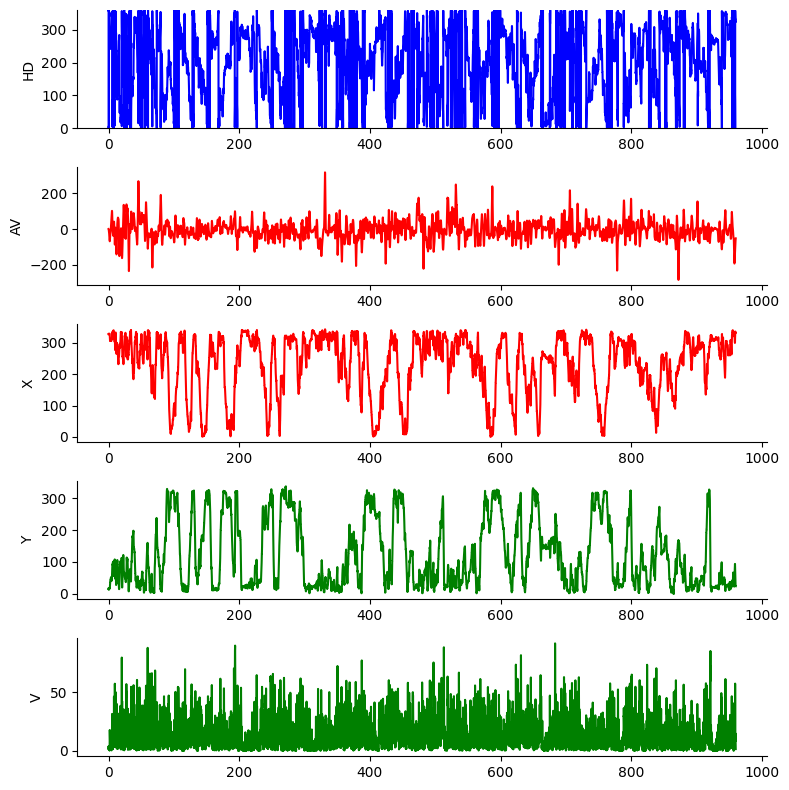

In [7]:
#plot the head direction and x location and y location over tim ein a 3*1 plot
fig, axs = plt.subplots(5, 1, figsize=(8, 8))

# Head Direction vs. Time
axs[0].plot(t, hd, label='Head Direction', color='b')
axs[0].set_ylabel('HD')
axs[0].set_ylim([0, 360])

#calculate angular speed from head direction and t. NB 359 and 1 degrees are close to each other
av = compute_angular_speed(hd, t, sigma=25)
axs[1].plot(t, av, label='Angular Speed', color='r')
axs[1].set_ylabel('AV')

# X Location vs. Time
axs[2].plot(t, x, label='X Location', color='r')
axs[2].set_ylabel('X')

# Y Location vs. Time
axs[3].plot(t, y, label='Y Location', color='g')
axs[3].set_ylabel('Y')

# velocity vs. Time
axs[4].plot(t, v, label='Velocity', color='g')
axs[4].set_ylabel('V')


sns.despine()
plt.tight_layout()


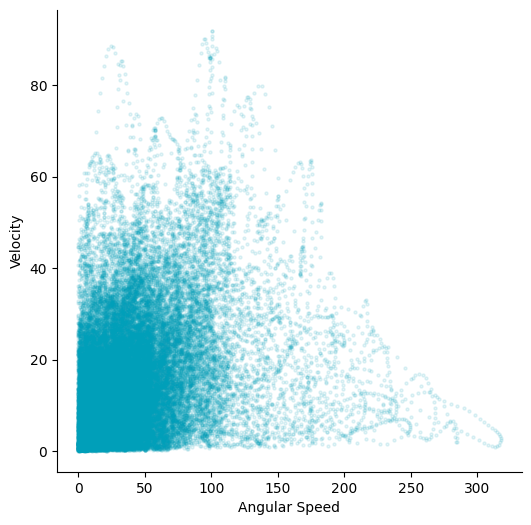

In [8]:
#check if av and v are negatively correlated
#do a scatter plot of av and v
fig, ax = plt.subplots(figsize=(6, 6))
v_nonana = v[~np.isnan(v)]
av_nonana = av[~np.isnan(v)]

# #filter out v < 5
# ind = v_nonana > 10
# v_nonana = v_nonana[ind]
# av_nonana = av_nonana[ind]

# #further filter out av < 10
# ind = av_nonana > 10
# v_nonana = v_nonana[ind]
# av_nonana = av_nonana[ind]

ax.scatter(np.abs(av_nonana), v_nonana, s=5, color='#009FB9', alpha=0.1)
ax.set_xlabel('Angular Speed')
ax.set_ylabel('Velocity')
sns.despine()

# #print pearson correlation coefficient and p-value
# from scipy.stats import pearsonr
# r, p = pearsonr(np.abs(av_nonana), v_nonana)
# print(f"Pearson Correlation Coefficient: {r:.3f}, p-value: {p:.3f}")

### Ceheck if theta power increase with angular speed

min av: 34.685234 max av: 39.349354 max v: 16.579733
min av: 37.714897 max av: 39.926342 max v: 18.510386
min av: 33.384716 max av: 39.637405 max v: 19.831884
min av: 30.374039 max av: 37.425106 max v: 18.944826


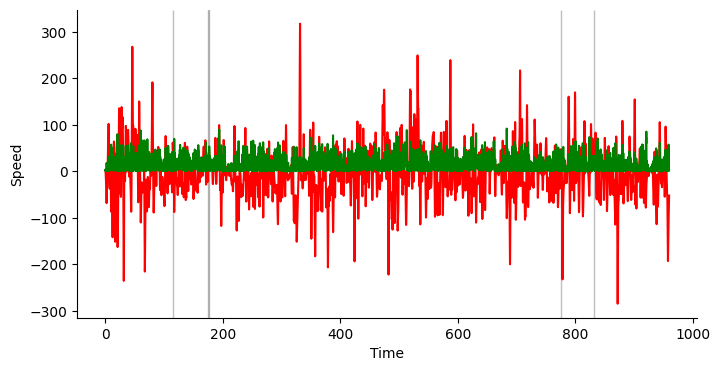

In [9]:
av = compute_angular_speed(hd, t, sigma=25)

periods = extract_angular_speed_periods(av, v, t, ang_speed_range=(30, 40), lin_speed_thresh=20, dur=0.6)

#plot the periods as a sanity check
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, av, label='Angular Speed', color='r')
ax.plot(t, v, label='Velocity', color='g')
for start, end in periods:
    ax.axvspan(start, end, color='gray', alpha=0.5)
    #print min and max av in the period and also max v in the period
    print('min av:', np.min(av[(t >= start) & (t <= end)]), 'max av:', np.max(av[(t >= start) & (t <= end)]), 'max v:', np.max(v[(t >= start) & (t <= end)]))
ax.set_xlabel('Time')
ax.set_ylabel('Speed')
sns.despine()

In [12]:
#test
fs = 250
theta_band = (6, 12)
gaussian_std = 0.5

mean_theta_power, mean_theta_frequency = compute_mean_theta_power_by_angspeed(av, v, t, eeg_filtered, eegtimes, fs=fs,
                                                                              angspeed_range=(0, 10), lin_speed_thresh=10, dur=1, absolute_power=False)
print(f"Mean Theta Power (0-10 cm/s): {mean_theta_power}", f"Mean Theta Frequency: {mean_theta_frequency:.2f} Hz")

#test
peak_theta_power, peak_theta_frequency = compute_theta_power(eeg, fs=fs, 
                                                             theta_band=theta_band, 
                                                             gaussian_std=gaussian_std,
                                                             absolute_power=False)
print(f"Peak Theta Power (Z-scored): {peak_theta_power}", f"Peak Theta Frequency: {peak_theta_frequency:.2f} Hz")

Mean Theta Power (0-10 cm/s): 8.116148962231325 Mean Theta Frequency: 8.57 Hz
Peak Theta Power (Z-scored): 7.061349437863382 Peak Theta Frequency: 8.84 Hz


In [31]:
#speed range: [0,10], [10,20], [20,30], [30,40], [40,50]

#smooth v to remove the noise

for angspeed_range in [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150)]:
    mean_theta_power, mean_theta_frequency = compute_mean_theta_power_by_angspeed(av, v, t, eeg_filtered, eegtimes, fs=fs,
                                                                                angspeed_range=angspeed_range, lin_speed_thresh=10, dur=0.6, absolute_power=False)
    print(f"Mean Theta Power ({angspeed_range[0]}-{angspeed_range[1]} degree/s): {mean_theta_power}", f"Mean Theta Frequency: {mean_theta_frequency:.2f} Hz")

Mean Theta Power (0-30 degree/s): 8.176503338964617 Mean Theta Frequency: 8.48 Hz
Mean Theta Power (30-60 degree/s): 8.210930051846475 Mean Theta Frequency: 8.30 Hz
Mean Theta Power (60-90 degree/s): 8.633408460102403 Mean Theta Frequency: 9.68 Hz
Mean Theta Power (90-120 degree/s): 6.915953180004313 Mean Theta Frequency: 7.81 Hz
Mean Theta Power (120-150 degree/s): nan Mean Theta Frequency: nan Hz


In [32]:
for angspeed_range in [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150)]:
    speed_periods = extract_angular_speed_periods(av, v, t, ang_speed_range=angspeed_range, lin_speed_thresh=10, dur=0.6)
    print(f"Speed Range {angspeed_range}: {len(speed_periods)} valid periods")


Speed Range (0, 30): 46 valid periods
Speed Range (30, 60): 4 valid periods
Speed Range (60, 90): 1 valid periods
Speed Range (90, 120): 1 valid periods
Speed Range (120, 150): 0 valid periods


'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_270819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_190719_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_200919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_150819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_180819_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrece

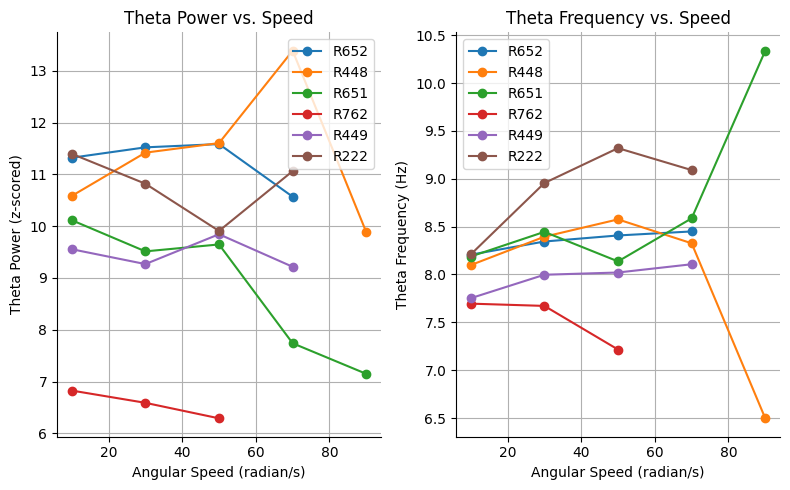

In [12]:
# Dictionary to store data for each rat
rat_data = {}

fs = 250

# Iterate through each session's results and store power/frequency per speed bin per rat
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)

                if data_dict is None:
                    continue

                eeg = data_dict['eeg']
                eeg_filtered = data_dict['eeg_filtered']
                eegtimes = data_dict['eegtimes']
                hd = data_dict['poh']
                v = data_dict['pov']
                t = data_dict['pot']
                
                #calculate angular speed
                av = compute_angular_speed(hd, t, sigma=25)
                
                # Initialize storage for each rat
                if ratname not in rat_data:
                    rat_data[ratname] = {angspeed_range: {'power': [], 'freq': []} for angspeed_range in [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]}
                    # rat_data[ratname] = {speed_range: {'power': [], 'freq': []} for speed_range in [(0, 20), (10,30), (20,40), (30,50)]}
                    
                # Compute power and frequency for each speed bin
                for angspeed_range in rat_data[ratname].keys():
                    mean_theta_power, mean_theta_frequency = compute_mean_theta_power_by_angspeed(av, v, t, eeg, eegtimes, fs=fs, theta_band=(6,12),
                                                                                                  angspeed_range=angspeed_range, lin_speed_thresh=20, dur=1.0, absolute_power=True)
                    if not np.isnan(mean_theta_power):  # Avoid NaN values
                        rat_data[ratname][angspeed_range]['power'].append(mean_theta_power)
                        rat_data[ratname][angspeed_range]['freq'].append(mean_theta_frequency)

# Compute mean power and frequency for each rat across all sessions in each speed bin
speed_bins = [10, 30, 50, 70, 90]
# speed_bins = [10, 20, 30, 40]  # Midpoints of speed ranges
all_rats_power = {}
all_rats_freq = {}

for ratname, data in rat_data.items():
    all_rats_power[ratname] = []
    all_rats_freq[ratname] = []
    
    for speed_range in data.keys():
        powers = np.array(data[speed_range]['power'])
        freqs = np.array(data[speed_range]['freq'])
        
        # Compute mean excluding NaNs
        mean_power = np.nanmean(powers) if len(powers) > 0 else np.nan
        mean_freq = np.nanmean(freqs) if len(freqs) > 0 else np.nan

        all_rats_power[ratname].append(mean_power)
        all_rats_freq[ratname].append(mean_freq)

# Plot Power vs Speed and Frequency vs Speed
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# Plot Power vs Speed
for ratname, powers in all_rats_power.items():
    axs[0].plot(speed_bins, powers, marker='o', linestyle='-', label=ratname)
axs[0].set_xlabel("Angular Speed (radian/s)")
axs[0].set_ylabel("Theta Power (z-scored)")
axs[0].set_title("Theta Power vs. Speed")
axs[0].legend()
axs[0].grid()

# Plot Frequency vs Speed
for ratname, freqs in all_rats_freq.items():
    axs[1].plot(speed_bins, freqs, marker='o', linestyle='-', label=ratname)
axs[1].set_xlabel("Angular Speed (radian/s)")
axs[1].set_ylabel("Theta Frequency (Hz)")
axs[1].set_title("Theta Frequency vs. Speed")
axs[1].legend()
axs[1].grid()

sns.despine()

plt.tight_layout()



### Now let's calculate a power spectrogram with time zero align to a speed of 10cm/s 

## all data

In [3]:
def extract_angspeed_periods(angular_speed, linear_speed, t, angspeed_range=(10, np.inf), lin_speed_thresh=10, dur=1):
    """
    Extracts periods where angular speed is within a given range and linear speed is below a threshold.

    Parameters:
    angular_speed (numpy array): Angular speed values at each timestamp.
    linear_speed (numpy array): Linear speed values at each timestamp.
    t (numpy array): Corresponding timestamps.
    angspeed_range (tuple): Angular speed range (min, max) to extract periods.
    lin_speed_thresh (float): Maximum linear speed threshold to exclude fast running (default: 10 cm/s).
    dur (float): Minimum duration for valid periods in seconds (default: 1s).

    Returns:
    list of tuples: [(start_time, end_time), ...] for periods meeting the criteria.
    """
    ang_min, ang_max = angspeed_range

    valid_indices = (angular_speed >= ang_min) & (angular_speed <= ang_max) & (linear_speed < lin_speed_thresh)

    periods = []
    if np.any(valid_indices):
        change_points = np.diff(valid_indices.astype(int))
        start_indices = np.where(change_points == 1)[0] + 1
        end_indices = np.where(change_points == -1)[0] + 1

        if valid_indices[0]:
            start_indices = np.insert(start_indices, 0, 0)
        if valid_indices[-1]:
            end_indices = np.append(end_indices, len(angular_speed))

        for start, end in zip(start_indices, end_indices):
            if (t[end - 1] - t[start]) >= dur:
                periods.append((t[start], t[end - 1]))

    return periods

def compute_time_evolving_spectrogram_angspeed(eeg, eegtimes, angular_speed, linear_speed, t, fs=250, angspeed_threshold=10, lin_speed_thresh=10, dur=1, window_length=500, step_size=100, freq_range=(2, 50)):
    """
    Computes time-evolving spectrograms aligned to the moment when angular speed first exceeds a threshold.

    Parameters:
    eeg (numpy array): EEG signal.
    eegtimes (numpy array): Corresponding timestamps for EEG.
    angular_speed (numpy array): Angular speed values.
    linear_speed (numpy array): Linear speed values (for filtering).
    t (numpy array): Corresponding timestamps.
    fs (int): EEG sampling frequency (default: 250 Hz).
    angspeed_threshold (float): Angular speed threshold for alignment (default: 10 degree/s).
    lin_speed_thresh (float): Maximum linear speed threshold to exclude fast running (default: 10 cm/s).
    dur (float): Duration of extracted period in seconds (default: 1s).
    window_length (int): Window length for spectrogram in milliseconds (default: 500ms).
    step_size (int): Step size for spectrogram in milliseconds (default: 100ms).
    freq_range (tuple): Frequency range to extract (default: 2-50 Hz).

    Returns:
    freqs (numpy array): Frequency values.
    times (numpy array): Time values relative to alignment point.
    aligned_spectrograms (list): List of spectrograms aligned to angular speed threshold crossing.
    """
    speed_periods = extract_angspeed_periods(angular_speed, linear_speed, t, angspeed_range=(angspeed_threshold, np.inf), lin_speed_thresh=lin_speed_thresh, dur=dur)
    aligned_spectrograms = []

    for start, end in speed_periods:
        speed_crossing_index = np.where((t >= start) & (angular_speed >= angspeed_threshold))[0][0]
        time_zero = t[speed_crossing_index]

        eeg_segment = eeg[(eegtimes >= time_zero - dur) & (eegtimes <= time_zero + dur)]
        if len(eeg_segment) == 0:
            continue

        nperseg = int((window_length / 1000) * fs)
        noverlap = int(((window_length - step_size) / 1000) * fs)

        freqs, times, Sxx = spectrogram(eeg_segment, fs=fs, nperseg=nperseg, noverlap=noverlap, mode='psd')

        freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
        Sxx = Sxx[freq_mask, :]

        times = times - dur
        aligned_spectrograms.append(Sxx)

    if not aligned_spectrograms:
        return np.array([]), np.array([]), []

    return freqs[freq_mask], times, aligned_spectrograms

base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)

                if data_dict is None:
                    continue

                eeg, eegtimes, v, t, hd = data_dict['eeg'], data_dict['eegtimes'], data_dict['pov'], data_dict['pot'], data_dict['poh']
                
                av = compute_angular_speed(hd, t, sigma=25) 

                print(f"Processing Rat: {ratname}")

                freqs, times, Sxx_trials = compute_time_evolving_spectrogram_angspeed(eeg, eegtimes, av, v, t, 
                                                                                      fs=250, angspeed_threshold=10, 
                                                                                      lin_speed_thresh=100, dur=1, 
                                                                                      window_length=500, step_size=100, 
                                                                                      freq_range=(2, 50))
                if len(Sxx_trials) == 0:
                    print(f"No valid trials for {ratname}. Skipping...")
                    continue  

                # min_length = min(Sxx.shape[1] for Sxx in Sxx_trials)
                # Sxx_trials_fixed = [Sxx[:, :min_length] for Sxx in Sxx_trials]
                #if trial lengths are different, delete those trials
                trial_lengths = [Sxx.shape[1] for Sxx in Sxx_trials]
                #delet shorter trials
                max_length = max(trial_lengths)
                Sxx_trials = [Sxx for Sxx in Sxx_trials if Sxx.shape[1] == max_length]
                Sxx_avg = np.mean(np.stack(Sxx_trials, axis=0), axis=0)

                Sxx_db = 10 * np.log10(Sxx_avg)

                baseline_idx = np.where((times >= -0.5) & (times <= 0))[0]
                baseline_power = np.mean(Sxx_db[:, baseline_idx], axis=1, keepdims=True)
                Sxx_db_norm = Sxx_db - baseline_power

                plt.figure(figsize=(8, 4))
                plt.imshow(Sxx_db_norm, aspect='auto', origin='lower',
                           extent=[times[0], times[-1], freqs[0], freqs[-1]], cmap='jet')
                plt.colorbar(label='Relative Power Change (dB)')
                plt.axvline(0, color='k', linestyle='--', label="Speed > 10 cm/s")
                plt.legend()

                filename_base = os.path.splitext(file)[0]
                plt.savefig(f'/home/zilong/Desktop/HDPhasePrecession/figures/thetapower_rotation/{filename_base}_thetapower.png')
                plt.close()


Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Ra

In [4]:
# Re-import necessary libraries after execution state reset

def extract_angspeed_periods(angular_speed, linear_speed, t, angspeed_threshold=10, lin_speed_thresh=10, dur=1):
    """
    Extracts periods where:
    1. Angular speed stays BELOW the threshold for `dur` before crossing.
    2. Angular speed stays ABOVE the threshold for `dur` after crossing.
    3. Linear speed remains BELOW `lin_speed_thresh` at all times.

    Parameters:
    angular_speed (numpy array): Angular speed values at each timestamp.
    linear_speed (numpy array): Linear speed values at each timestamp.
    t (numpy array): Corresponding timestamps.
    angspeed_threshold (float): Angular speed threshold to define turning (default: 10 rad/s).
    lin_speed_thresh (float): Maximum linear speed threshold to exclude fast running (default: 10 cm/s).
    dur (float): Duration before and after turning that conditions must hold (default: 1s).

    Returns:
    list of tuples: [(start_time, end_time), ...] for periods meeting the criteria.
    """
    periods = []
    
    # Find indices where angular speed crosses the threshold
    crossing_indices = np.where((angular_speed[:-1] < angspeed_threshold) & (angular_speed[1:] >= angspeed_threshold))[0] + 1
    
    for cross_idx in crossing_indices:
        # Define pre-turn and post-turn time ranges
        pre_start_time = t[cross_idx] - dur
        post_end_time = t[cross_idx] + dur

        # Get indices for pre and post conditions
        pre_indices = np.where((t >= pre_start_time) & (t < t[cross_idx]))[0]
        post_indices = np.where((t > t[cross_idx]) & (t <= post_end_time))[0]

        # Ensure we have enough data points
        if len(pre_indices) == 0 or len(post_indices) == 0:
            continue
        
        # Check that angular speed is BELOW the threshold BEFORE turning
        if not np.all(angular_speed[pre_indices] < angspeed_threshold):
            continue
        
        # Check that angular speed is ABOVE the threshold AFTER turning
        if not np.all(angular_speed[post_indices] >= angspeed_threshold):
            continue

        # Check that linear speed is always below the threshold in the entire duration
        all_indices = np.concatenate((pre_indices, post_indices))
        if not np.all(linear_speed[all_indices] < lin_speed_thresh):
            continue

        # Append valid period
        periods.append((t[pre_indices[0]], t[post_indices[-1]]))

    return periods

def compute_time_evolving_spectrogram_angspeed(eeg, eegtimes, angular_speed, linear_speed, t, fs=250, angspeed_threshold=10, lin_speed_thresh=10, dur=1, window_length=500, step_size=100, freq_range=(2, 50)):
    """
    Computes time-evolving spectrograms aligned to the moment when angular speed first exceeds a threshold.

    Parameters:
    eeg (numpy array): EEG signal.
    eegtimes (numpy array): Corresponding timestamps for EEG.
    angular_speed (numpy array): Angular speed values.
    linear_speed (numpy array): Linear speed values (for filtering).
    t (numpy array): Corresponding timestamps.
    fs (int): EEG sampling frequency (default: 250 Hz).
    angspeed_threshold (float): Angular speed threshold for alignment (default: 10 rad/s).
    lin_speed_thresh (float): Maximum linear speed threshold to exclude fast running (default: 10 cm/s).
    dur (float): Duration of extracted period in seconds (default: 1s).
    window_length (int): Window length for spectrogram in milliseconds (default: 500ms).
    step_size (int): Step size for spectrogram in milliseconds (default: 100ms).
    freq_range (tuple): Frequency range to extract (default: 2-50 Hz).

    Returns:
    freqs (numpy array): Frequency values.
    times (numpy array): Time values relative to alignment point.
    aligned_spectrograms (list): List of spectrograms aligned to angular speed threshold crossing.
    """
    speed_periods = extract_angspeed_periods(angular_speed, linear_speed, t, angspeed_threshold=angspeed_threshold, lin_speed_thresh=lin_speed_thresh, dur=dur)
    aligned_spectrograms = []

    for start, end in speed_periods:
        speed_crossing_index = np.where((t >= start) & (angular_speed >= angspeed_threshold))[0][0]
        time_zero = t[speed_crossing_index]

        eeg_segment = eeg[(eegtimes >= time_zero - dur) & (eegtimes <= time_zero + dur)]
        if len(eeg_segment) == 0:
            continue

        nperseg = int((window_length / 1000) * fs)
        noverlap = int(((window_length - step_size) / 1000) * fs)

        freqs, times, Sxx = spectrogram(eeg_segment, fs=fs, nperseg=nperseg, noverlap=noverlap, mode='psd')

        freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
        Sxx = Sxx[freq_mask, :]

        times = times - dur
        aligned_spectrograms.append(Sxx)

    if not aligned_spectrograms:
        return np.array([]), np.array([]), []

    return freqs[freq_mask], times, aligned_spectrograms


Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Ra

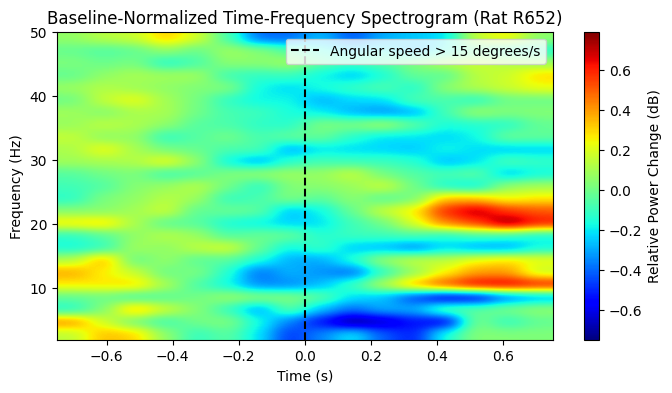

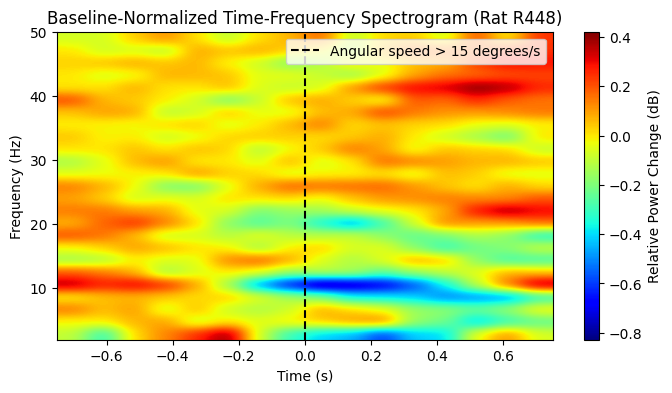

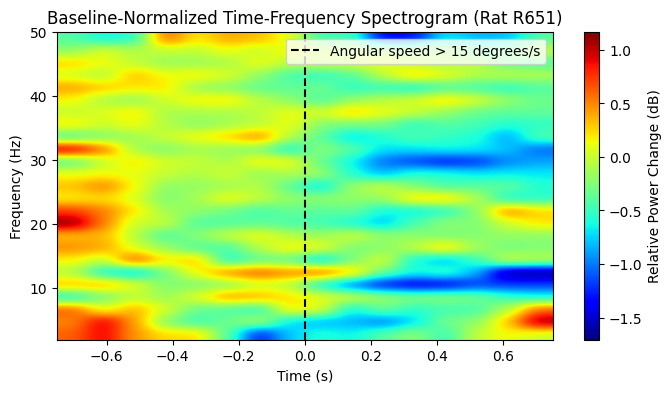

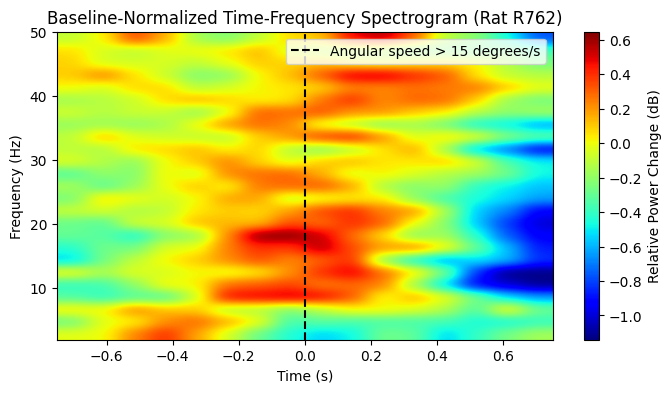

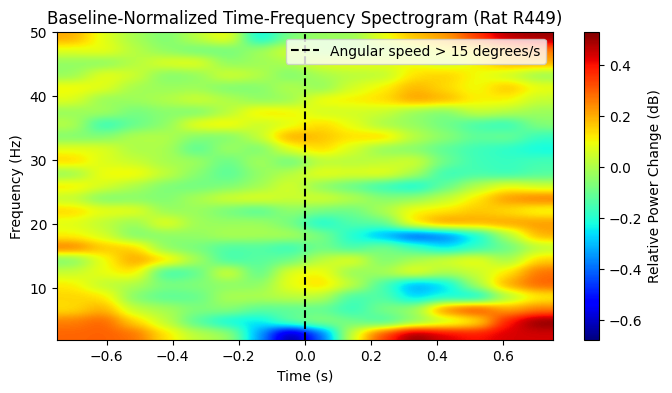

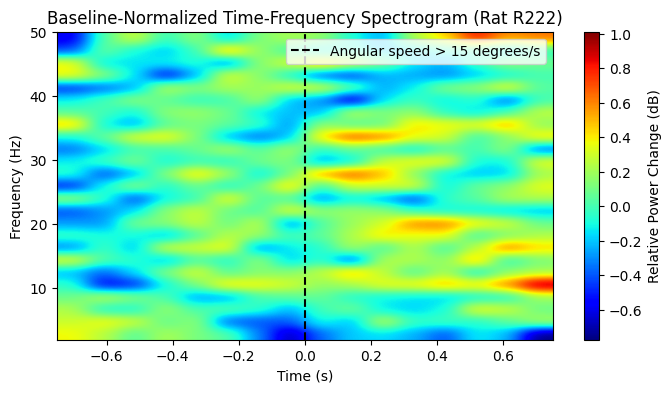

In [5]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'
rat_spectrograms = {}  # Dictionary to accumulate data for each rat


for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                ratname = file.split('_')[0]  # Extract rat name from filename
                data_dict = load_data(ratname, file_path)

                if data_dict is None:
                    continue

                eeg, eegtimes, v, t, hd = data_dict['eeg'], data_dict['eegtimes'], data_dict['pov'], data_dict['pot'], data_dict['poh']
                
                av = compute_angular_speed(hd, t, sigma=25)

                print(f"Processing Rat: {ratname}")

                # Compute spectrogram\
                dur = 1
                freqs, times, Sxx_trials = compute_time_evolving_spectrogram_angspeed(eeg, eegtimes, av, v, t,
                                                                                        fs=250, angspeed_threshold=10,
                                                                                        lin_speed_thresh=100, dur=dur,
                                                                                        window_length=500, step_size=100,
                                                                                        freq_range=(2, 50))

                if len(Sxx_trials) == 0:
                    print(f"No valid trials for {ratname}. Skipping...")
                    continue  

                # Ensure all spectrograms have the same time bin length
                #using max_length to delete those trials with different lengths
                trial_lengths = [Sxx.shape[1] for Sxx in Sxx_trials]
                max_length = max(trial_lengths)
                Sxx_trials_fixed = [Sxx for Sxx in Sxx_trials if Sxx.shape[1] == max_length]
                

                # Store in dictionary (accumulate sessions per rat)
                if ratname not in rat_spectrograms:
                    rat_spectrograms[ratname] = []
                rat_spectrograms[ratname].extend(Sxx_trials_fixed)  # Append all sessions for this rat


for ratname, Sxx_list in rat_spectrograms.items():
    if len(Sxx_list) == 0:
        continue  

    # Convert to numpy array and compute the mean across all trials of the rat
    Sxx_avg = np.mean(np.stack(Sxx_list, axis=0), axis=0)

    # Convert to dB
    Sxx_db = 10 * np.log10(Sxx_avg)

    # Baseline normalization (-0.5s to 0s before speed threshold crossing)
    baseline_idx = np.where((times >= -dur) & (times <= 0))[0]
    baseline_power = np.mean(Sxx_db[:, baseline_idx], axis=1, keepdims=True)
    Sxx_db_norm = Sxx_db - baseline_power

    # **Plot a single spectrogram for the entire rat**
    plt.figure(figsize=(8, 4))
    #gaussian smoothing Sxx_db_norm
    # Sxx_db_norm = gaussian_filter1d(Sxx_db_norm, sigma=3)
    plt.imshow(Sxx_db_norm, aspect='auto', origin='lower',
               extent=[times[0], times[-1], freqs[0], freqs[-1]], cmap='jet', interpolation='gaussian')

    plt.colorbar(label='Relative Power Change (dB)')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"Baseline-Normalized Time-Frequency Spectrogram (Rat {ratname})")
    plt.axvline(0, color='k', linestyle='--', label="Angular speed > 15 degrees/s")
    plt.legend()

    # Save the figure
    # plt.savefig(os.path.join(output_dir, f"{ratname}_thetapower.png"))
    # plt.close()

print("Finished processing all rats.")


Finished processing all rats.


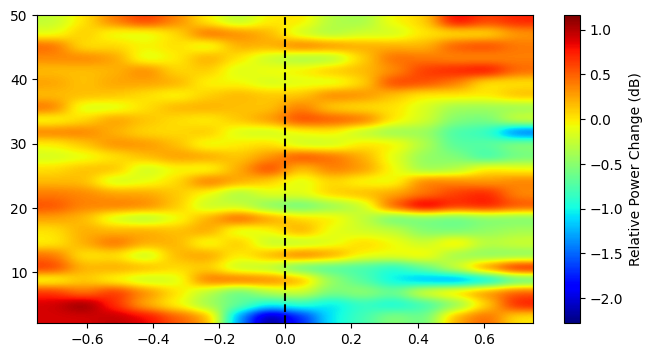

In [6]:
Sxx_db_norm_all = []

for ratname, Sxx_list in rat_spectrograms.items():
    if len(Sxx_list) == 0:
        continue  

    # Convert to numpy array and compute the mean across all trials of the rat
    Sxx_avg = np.mean(np.stack(Sxx_list, axis=0), axis=0)

    # Convert to dB
    Sxx_db = 10 * np.log10(Sxx_avg)

    # Baseline normalization (-0.5s to 0s before speed threshold crossing)
    baseline_idx = np.where((times >= -dur) & (times <= 0))[0]
    baseline_power = np.mean(Sxx_db[:, baseline_idx], axis=1, keepdims=True)
    Sxx_db_norm = Sxx_db - baseline_power
    
    #normalize Sxx_db_norm before appending
    Sxx_db_norm = (Sxx_db_norm - np.mean(Sxx_db_norm)) / np.std(Sxx_db_norm)

    Sxx_db_norm_all.append(Sxx_db_norm)
    # Save the figure
    # plt.savefig(os.path.join(output_dir, f"{ratname}_thetapower.png"))
    # plt.close()

print("Finished processing all rats.")

#take the mean of all rats
Sxx_db_norm_all = np.stack(Sxx_db_norm_all, axis=0)

#plot the mean of all rats
plt.figure(figsize=(8, 4))
Sxx_db_norm_mean = np.mean(Sxx_db_norm_all, axis=0)
plt.imshow(Sxx_db_norm_mean, aspect='auto', origin='lower',
           extent=[times[0], times[-1], freqs[0], freqs[-1]], cmap='jet', interpolation='gaussian')
plt.colorbar(label='Relative Power Change (dB)')

plt.axvline(0, color='k', linestyle='--', label="Angular speed > 15 degrees/s")